In [104]:
#Things to import
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time, tqdm, json, re, requests, os, csv
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import snscrape.modules.twitter as sntwitter
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import seaborn as sns

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [150]:
#21/05/2020 -> 05/02/2021
#21 Maj - 5 Feb
query = "(#stopthesteal) lang:en until:2021-02-05 since:2020-05-21"
#test_query = "(#stopthesteal) lang:en until:2021-01-07 since:2021-01-05"
tweets = []

In [151]:
def log(tweet, logfile,output_path=os.getcwd()):
    """Logging function to create a log of the scraping status"""
    #Open or create the csv log file
    if os.path.isfile(logfile):
        log = open(logfile,'a')
    else:
        log = open(logfile, 'w')
        header = ['timestamp', 'status_code', 'length', 'output_file']
        log.write(';'.join(header) + '\n')
    
    #Get log information
    #If the tweet did not fail, the status code is 200
    status_code = 200
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    #Should be 27 values along with the tweet
    length = len(tweet)
    
    #append to log file
    with open(logfile, 'a') as log:
        log.write(f'{timestamp};{status_code};{length};{output_path}' + "\n")
        

In [ ]:
#Getting the tweets:
logfile = 'tweet_scrape_log.csv'
for tweet in tqdm.tqdm(sntwitter.TwitterSearchScraper(query).get_items()):
    try:
        tweets.append([tweet.date, tweet.content])
    except Exception as e:
        print('Something went wrong')
        print(e)
        print(f'Last tweet: {tweet.date} {tweet.content}')
        with open('tweets_backup.csv', 'w', encoding='utf8') as f:
            write = csv.writer(f)
            write.writerow(['datetime', 'text'])
            write.writerows(tweets)
        continue
    log(vars(tweet), logfile)

4579it [03:00, 25.09it/s]

In [122]:
#If everything went to plan, save the list as a csv
with open('tweets.csv', 'w', encoding='utf8') as f:
    write = csv.writer(f)
    write.writerow(['datetime', 'text'])
    write.writerows(tweets)

In [123]:
#Get dataframe from csv
df_tweets = pd.read_csv('tweets.csv')
df_tweets['datetime'] = pd.to_datetime(df_tweets['datetime'])

In [32]:
#Creating our Dataframe from list (only if everyhting went wrong)
#df_tweets = pd.DataFrame(tweets, columns=['datetime', 'text'])

In [124]:
df_tweets

,datetime,text
0,2021-02-04 23:59:27+00:00,@nprpolitics A dangerous precedent has now bee...
1,2021-02-04 23:49:06+00:00,@BrendanKeefe Republican party has shrunk dram...
2,2021-02-04 23:35:19+00:00,ARIZONA: Gosar Slams Establishment Republicans...
3,2021-02-04 23:11:26+00:00,.@GOP always love to play victims w/o taking r...
4,2021-02-04 23:10:16+00:00,Trump's law: is the Earth more spherical than ...
...,...,...
770,2021-01-30 19:36:08+00:00,@laurenboebert tweeting other people’s jokes a...
771,2021-01-30 19:27:39+00:00,@boltsbucsbabe @BenRaviolio @orlandosentinel I...
772,2021-01-30 19:13:08+00:00,President Trump won by a landslide!!!! #stopth...
773,2021-01-30 18:45:44+00:00,@laurenboebert Anyone who said #stopthesteal s...


In [125]:
#Working with the tweet text data
dirty_text = df_tweets['text'].copy()

In [126]:
def clean(array_of_tweets):
    """This function will take a list of tweets and clean them in the following manner:
    Make lowercase, Replace mentions with @user, and remove any links"""
    for i in range(len(array_of_tweets)):
        #make lower() and strip
        new_text = array_of_tweets[i].lower().strip()
        #replace @user 
        new_text = re.sub(r'\@\w+', '', new_text)
        #remove links
        new_text = re.sub(r'https?://\w+\.\w+/?\w+', '', new_text)
        #remove (video)
        new_text = re.sub(r'\(video\)', '', new_text)
        #remove \r and \n
        new_text = re.sub(r'\r', '', new_text)
        new_text = re.sub(r'\n', '', new_text)
        #remove hashtags
        new_text = re.sub(r'#\w+', '', new_text)
        array_of_tweets[i] = new_text
    return array_of_tweets

In [127]:
#Get clean_text
clean_text = clean(dirty_text)

In [128]:
#testing the text
for i in range(5):
    print(df_tweets['text'][i])
    print()
    print(clean_text[i])
    print()

@nprpolitics A dangerous precedent has now been set the left is now actively trying silence the minority party #wontforget #GOP #TrumpWon #StopTheSteal

 a dangerous precedent has now been set the left is now actively trying silence the minority party    

@BrendanKeefe Republican party has shrunk dramatically in the last two months: poll #Republicans #GOP #Trump #stopthesteal https://t.co/t0BILSi237

 republican party has shrunk dramatically in the last two months: poll     

ARIZONA: Gosar Slams Establishment Republicans For Labeling #StopTheSteal Push For Election Integrity ‘Sedition’ via @nationalfile https://t.co/0f6Kh970Hb

arizona: gosar slams establishment republicans for labeling  push for election integrity ‘sedition’ via  

.@GOP always love to play victims w/o taking responsibility for thier actions! #CancelCulture is the new #StopTheSteal for Republicans! It helps them unite their supporters &amp; fundraise against the so-called "radical left."

. always love to play victi

In [129]:
#Making a column with the cleaned text
df_tweets['cleaned text'] = clean_text

In [130]:
df_tweets

,datetime,text,cleaned text
0,2021-02-04 23:59:27+00:00,@nprpolitics A dangerous precedent has now bee...,a dangerous precedent has now been set the le...
1,2021-02-04 23:49:06+00:00,@BrendanKeefe Republican party has shrunk dram...,republican party has shrunk dramatically in t...
2,2021-02-04 23:35:19+00:00,ARIZONA: Gosar Slams Establishment Republicans...,arizona: gosar slams establishment republicans...
3,2021-02-04 23:11:26+00:00,.@GOP always love to play victims w/o taking r...,. always love to play victims w/o taking respo...
4,2021-02-04 23:10:16+00:00,Trump's law: is the Earth more spherical than ...,trump's law: is the earth more spherical than ...
...,...,...,...
770,2021-01-30 19:36:08+00:00,@laurenboebert tweeting other people’s jokes a...,tweeting other people’s jokes as your own now?
771,2021-01-30 19:27:39+00:00,@boltsbucsbabe @BenRaviolio @orlandosentinel I...,it’s fake news!
772,2021-01-30 19:13:08+00:00,President Trump won by a landslide!!!! #stopth...,president trump won by a landslide!!!! !!! !!!!!
773,2021-01-30 18:45:44+00:00,@laurenboebert Anyone who said #stopthesteal s...,anyone who said should be booted from congress


In [131]:
#Using Vader to find perform sentiment analysis
analyzer = SentimentIntensityAnalyzer()
sentiment = []
for i in tqdm.tqdm(df_tweets['cleaned text'].values):
    score = analyzer.polarity_scores(i)['compound']
    sentiment.append(score)

100%|██████████████████████████████████████████████████████████████████████████████| 775/775 [00:00<00:00, 5331.81it/s]


In [132]:
df_tweets['sentiment_score'] = sentiment

In [133]:
for i in range(10):
    print(df_tweets['cleaned text'][i], df_tweets['sentiment_score'][i])
    print()

 a dangerous precedent has now been set the left is now actively trying silence the minority party     0.2263

 republican party has shrunk dramatically in the last two months: poll      0.4019

arizona: gosar slams establishment republicans for labeling  push for election integrity ‘sedition’ via   0.3818

. always love to play victims w/o taking responsibility for thier actions!  is the new  for republicans! it helps them unite their supporters &amp; fundraise against the so-called "radical left." 0.8856

trump's law: is the earth more spherical than round... like a pillowcase full of doorknobs     0.3612

  who stole her ass?  -0.5423

 not testifying in his  trial is essentially throwing  under the bus. trump won’t say in court what he said at the   rally. rioters said  invited em to the . trump don’t give a shit abt ! those rioters are on their own.  -0.5983

voting technology company  files $2.7 billion lawsuit against , rudy giuliani and sidney powell over 'disinformation campai

In [134]:
df_tweets

,datetime,text,cleaned text,sentiment_score
0,2021-02-04 23:59:27+00:00,@nprpolitics A dangerous precedent has now bee...,a dangerous precedent has now been set the le...,0.2263
1,2021-02-04 23:49:06+00:00,@BrendanKeefe Republican party has shrunk dram...,republican party has shrunk dramatically in t...,0.4019
2,2021-02-04 23:35:19+00:00,ARIZONA: Gosar Slams Establishment Republicans...,arizona: gosar slams establishment republicans...,0.3818
3,2021-02-04 23:11:26+00:00,.@GOP always love to play victims w/o taking r...,. always love to play victims w/o taking respo...,0.8856
4,2021-02-04 23:10:16+00:00,Trump's law: is the Earth more spherical than ...,trump's law: is the earth more spherical than ...,0.3612
...,...,...,...,...
770,2021-01-30 19:36:08+00:00,@laurenboebert tweeting other people’s jokes a...,tweeting other people’s jokes as your own now?,0.2500
771,2021-01-30 19:27:39+00:00,@boltsbucsbabe @BenRaviolio @orlandosentinel I...,it’s fake news!,-0.5255
772,2021-01-30 19:13:08+00:00,President Trump won by a landslide!!!! #stopth...,president trump won by a landslide!!!! !!! !!!!!,0.7067
773,2021-01-30 18:45:44+00:00,@laurenboebert Anyone who said #stopthesteal s...,anyone who said should be booted from congress,0.0000


In [135]:
#calculating the average of all sentiment
total = 0
for i in df_tweets['sentiment_score']:
    total += i
avg = total / len(df_tweets['sentiment_score'])

In [136]:
avg

-0.07720851612903226

In [137]:
#Creating date column with the date 
df_tweets['date'] = df_tweets['datetime'].dt.date

In [138]:
df_tweets.head(3)

,datetime,text,cleaned text,sentiment_score,date
0,2021-02-04 23:59:27+00:00,@nprpolitics A dangerous precedent has now bee...,a dangerous precedent has now been set the le...,0.2263,2021-02-04
1,2021-02-04 23:49:06+00:00,@BrendanKeefe Republican party has shrunk dram...,republican party has shrunk dramatically in t...,0.4019,2021-02-04
2,2021-02-04 23:35:19+00:00,ARIZONA: Gosar Slams Establishment Republicans...,arizona: gosar slams establishment republicans...,0.3818,2021-02-04


In [139]:
#Splitting the dataframe by date, getting the sum and count of the sentiment to calculate average
tweets_by_date = df_tweets.groupby('date')['sentiment_score'].agg(['sum', 'count'])

In [140]:
#Creating an average column
tweets_by_date['avg'] = tweets_by_date['sum'] / tweets_by_date['count']

In [141]:
#Drop sum and rename count
tweets_by_date.drop('sum', axis=1, inplace=True)
tweets_by_date.columns = ['tweet_count', 'total_avg']

In [142]:
#Getting all the positive values
positive_sentiment = df_tweets[df_tweets['sentiment_score'] > 0].groupby('date')['sentiment_score'].agg(['sum', 'count'])
#Getting the positive average
positive_sentiment['positive_avg'] = positive_sentiment['sum'] / positive_sentiment['count']
print(positive_sentiment)

#Getting all the negative values
negative_sentiment = df_tweets[df_tweets['sentiment_score'] < 0].groupby('date')['sentiment_score'].agg(['sum', 'count']) 
#Getting negative average
negative_sentiment['negative_avg'] = negative_sentiment['sum'] / negative_sentiment['count']
print(negative_sentiment)

                sum  count  positive_avg
date                                    
2021-01-30   3.7318     10      0.373180
2021-01-31   8.3524     20      0.417620
2021-02-01  24.0089     54      0.444609
2021-02-02  19.3368     43      0.449693
2021-02-03  29.9821     56      0.535395
2021-02-04  13.0715     32      0.408484
                sum  count  negative_avg
date                                    
2021-01-30  -6.7541     13     -0.519546
2021-01-31 -26.4528     48     -0.551100
2021-02-01 -34.9826     58     -0.603148
2021-02-02 -34.7039     68     -0.510351
2021-02-03 -37.4106     66     -0.566827
2021-02-04 -18.0161     36     -0.500447


In [143]:
#Dropping sum
positive_sentiment.drop('sum', axis=1, inplace=True)
negative_sentiment.drop('sum', axis=1, inplace=True)
# Renaming the columns
positive_sentiment.columns = ['positive_count', 'positive_avg']
negative_sentiment.columns = ['negative_count', 'negative_avg']

In [144]:
#Adding the positive and the negative to combined_tweets
all_sentiment = positive_sentiment.join(negative_sentiment, how='inner')
df_combined_tweets = tweets_by_date.join(all_sentiment, how='inner')
#Add day column for plots
df_combined_tweets['day'] = df_combined_tweets.index

In [145]:
df_combined_tweets

,tweet_count,total_avg,positive_count,positive_avg,negative_count,negative_avg,day
date,,,,,,,
2021-01-30,30,-0.100743,10,0.373180,13,-0.519546,2021-01-30
2021-01-31,90,-0.201116,20,0.417620,48,-0.551100,2021-01-31
2021-02-01,143,-0.076739,54,0.444609,58,-0.603148,2021-02-01
2021-02-02,148,-0.103832,43,0.449693,68,-0.510351,2021-02-02
2021-02-03,215,-0.034551,56,0.535395,66,-0.566827,2021-02-03
2021-02-04,149,-0.033185,32,0.408484,36,-0.500447,2021-02-04


In [146]:
df_combined_tweets.to_csv('combined_tweets.csv', encoding='utf8')

<AxesSubplot:xlabel='date', ylabel='total_avg'>

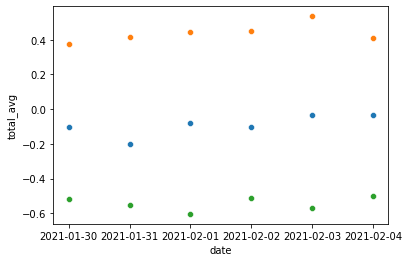

In [147]:
#Scatterplot over the average
f, ax = plt.subplots()
sns.scatterplot(x='date', y='total_avg', data=df_combined_tweets, ax=ax)
sns.scatterplot(x='date', y='positive_avg', data=df_combined_tweets, ax=ax)
sns.scatterplot(x='date', y='negative_avg', data=df_combined_tweets, ax=ax)

<AxesSubplot:xlabel='datetime', ylabel='sentiment_score'>

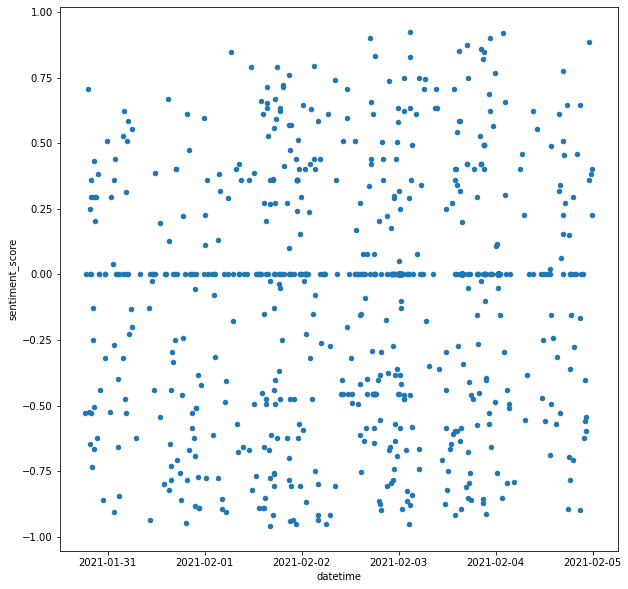

In [148]:
df_tweets.plot(x='datetime', y='sentiment_score', kind='scatter', figsize=(10,10))

In [274]:
#Show all in a scatter plot -> motivate where we go
#Average sentiment of all tweets over time
#Average sentiment of negative tweets over time (as well)
#Make curve for positive and negative

#Bag of words -> look at what words are the most negative/positive
# Word cloud 

#Polarization

#Overvejelser:
# Lexicon limitations -> words that have an absolute value